<a href="https://colab.research.google.com/github/nish700/Time-Series-forecasting/blob/main/nifty50_open_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nifty50 open price prediction using deep learning forecasting techniques

Predicting the open price of nifty 50 index using time series forecasting techniques. The data for the same has been downloaded from nseindia.com website. Univariate forecasting is done here , as only Open Price of Nifty50 index is taken for prediction purpose. Wavelet transformation is applied to the dataset to smoothen out the data and remove large variations in the open price. Then the stacked deep learning models such as Stacked LSTM, Stacked CNN and a combination of CNN-LSTM layers are used to predict the future values. Wavelet transformation helps to improve the accuracy of the prediction. The predicted values are compared with the true values and errors obtained are within comparable limits. True and predicted values are also plotted in graphs for visual representation. Python has been used for coding and tensorflow framework is used for coding deep learning architectures.

###import and clean up

In [ ]:
# !pip install openpyxl==3.0.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import math
import pywt
from statsmodels.robust import mad

from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.nn import leaky_relu
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

In [ ]:
nifty_data = pd.read_excel('/content/drive/MyDrive/Datasets/MTP_data/final_data_v2.xlsx')

In [ ]:
nifty_data.shape

(2882, 14)

In [ ]:
nifty_data.isna().sum()

Date                                   0
Open                                   0
High                                   0
Low                                    0
Close                                  0
Shares Traded                          0
Turnover (Rs. Cr)                      0
VIX Price                              0
VIX Open                               0
VIX High                               0
VIX Low                                0
VIX Chg%                               0
Net Purchase / Sales FII Rs Crores    44
Net Purchase / Sales DII Rs Crores    44
dtype: int64

In [ ]:
nifty_data_1 = nifty_data[['Date','Open','High','Low','Close']]
nifty_data_1.head()

,Date,Open,High,Low,Close
0,2010-04-01,5249.20,5298.60,5249.20,5290.50
1,2010-04-05,5291.40,5377.55,5291.40,5368.40
2,2010-04-06,5369.65,5388.65,5351.70,5366.00
3,2010-04-07,5365.70,5399.65,5345.05,5374.65
4,2010-04-08,5376.30,5383.65,5290.25,5304.45


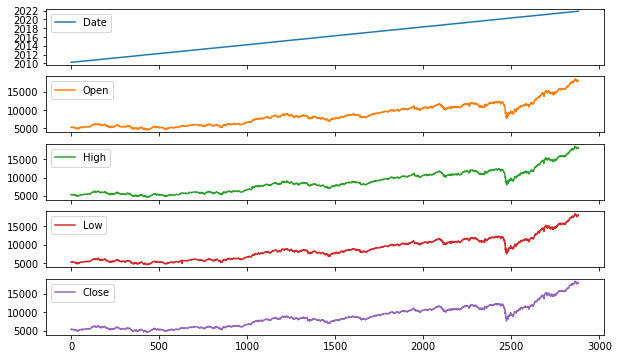

In [ ]:
nifty_data_1.plot(figsize=(10,6),subplots=True)
plt.show()

               Open     High      Low    Close
Date                                          
2010-04-01  5249.20  5298.60  5249.20  5290.50
2010-04-05  5291.40  5377.55  5291.40  5368.40
2010-04-06  5369.65  5388.65  5351.70  5366.00
2010-04-07  5365.70  5399.65  5345.05  5374.65
2010-04-08  5376.30  5383.65  5290.25  5304.45


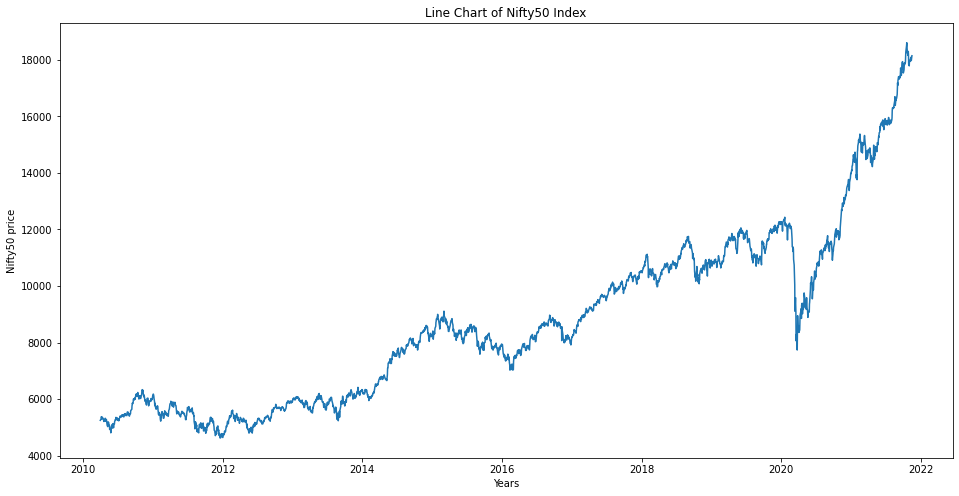

In [ ]:
nifty_data_2 = nifty_data_1.set_index(keys='Date')
print(nifty_data_2.head())

plt.figure(figsize=(16,8))
plt.plot(nifty_data_2['Open'])
plt.xlabel('Years')
plt.ylabel('Nifty50 price')
plt.title('Line Chart of Nifty50 Index')
plt.show()

In [ ]:
nifty_data_2 = nifty_data_2[['Open']]
nifty_data_2.head()

,Open
Date,
2010-04-01,5249.20
2010-04-05,5291.40
2010-04-06,5369.65
2010-04-07,5365.70
2010-04-08,5376.30


In [ ]:
nifty_data_2.shape

(2882, 1)

### Wavelet transform

In [ ]:
def waveletSmooth(x , wavelet='haar',level = 1, declevel = 3):
  #calculate wavelet coefficient
  coeff = pywt.wavedec(x , wavelet, mode = 'per',level = declevel,axis=0)
  #threshold
  sigma = mad(coeff[-level])
  upper_thresh = sigma * np.sqrt(2 * np.log(len(x)))
  coeff[1:] = (pywt.threshold(i ,value = upper_thresh , mode = 'soft') for i in coeff[1:])
  #reconstruct the signal using  threshold coefficient
  y = pywt.waverec(coeff , wavelet , mode = 'per', axis=0)
  f, ax = plt.subplots(figsize=(8,6))
  plt.plot(x , color='b',alpha = 0.5)
  plt.plot(y , color='r')
  ax.set_xlim(1, len(y))
  plt.show()

  return y

In [ ]:
data = nifty_data_2

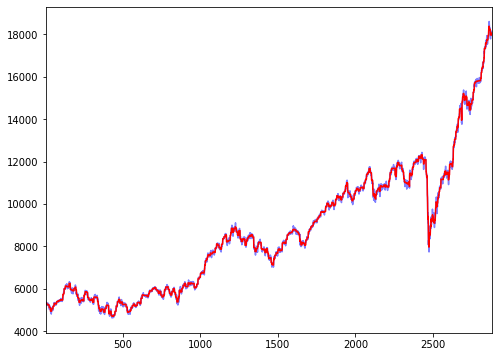

In [ ]:
w = waveletSmooth(data.values)

In [ ]:
w

array([[ 5331.20625],
       [ 5331.20625],
       [ 5331.20625],
       ...,
       [17962.8125 ],
       [18059.275  ],
       [18059.275  ]])

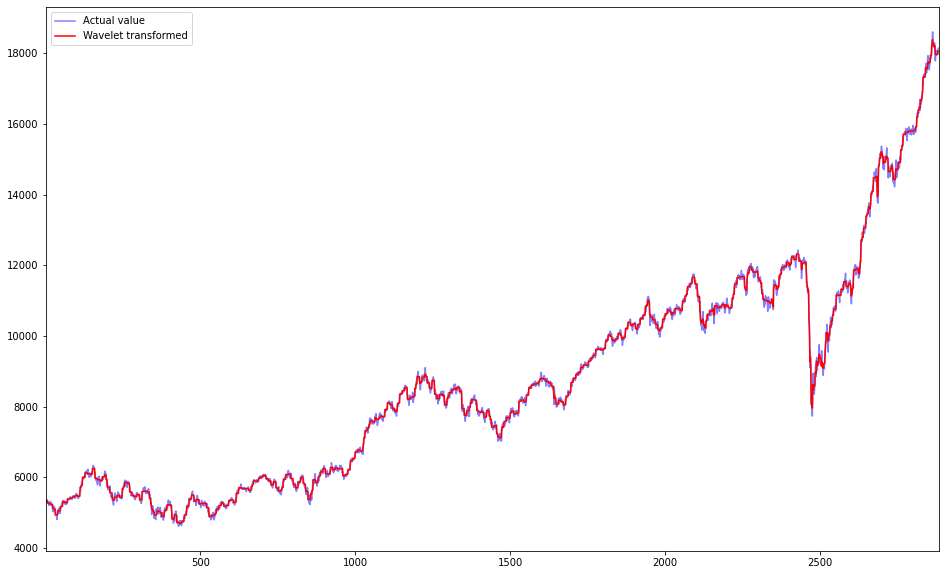

In [ ]:
f, ax = plt.subplots(figsize=(16,10))
plt.plot(nifty_data_2.values , color='b',alpha = 0.5, label='Actual value')
plt.plot(w , color='r', label='Wavelet transformed')
ax.set_xlim(1, len(w))
ax.legend()
plt.show()

### Scaling and splitting

In [ ]:
# callback = LearningRateScheduler(scheduler(epochs))

In [ ]:
#scaling the records
scaler = MinMaxScaler(feature_range = (0,1))
nifty_data_3 = scaler.fit_transform(w.reshape(-1,1))

In [ ]:
nifty_data_3

array([[0.04583589],
       [0.04583589],
       [0.04583589],
       ...,
       [0.96967399],
       [0.97672897],
       [0.97672897]])

In [ ]:
def load_data( index_price ,seq_length):
  data_raw = index_price
  data_lst = []

  #create all possible of sequence
  for index in range(len(data_raw) - seq_length):
    data_lst.append(data_raw[index: index + seq_length])

  data_lst = np.array(data_lst)

  train_set = int(np.round(0.8 * data_lst.shape[0]))
  test_set = int(np.round(0.2 * data_lst.shape[0]))

  X_train = data_lst[:train_set, :-1,:]
  X_val = data_lst[train_set:, :-1]

  y_train = data_lst[:train_set, -1, :]
  y_val = data_lst[train_set:,-1,:]

  return X_train, X_val , y_train, y_val

In [ ]:
epochs = 300
batch_size = 64
seq_len = 6

In [ ]:
X_train, X_val, y_train, y_val = load_data(nifty_data_3, seq_len)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2301, 5, 1), (575, 5, 1), (2301, 1), (575, 1))

In [ ]:
X_train.shape

(2301, 5, 1)

### Stacked LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
# model.add(Dense(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam', metrics = RootMeanSquaredError())

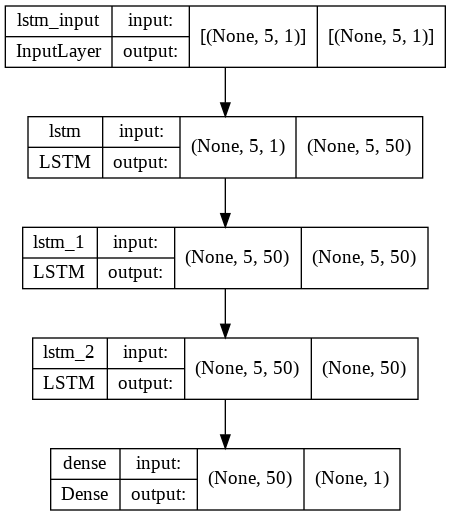

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t0 = time.time()
model_hist_1 = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 15s 95ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 7.0431e-04 - val_root_mean_squared_error: 0.0265
Epoch 2/300
36/36 [==============================] - 1s 26ms/step - loss: 5.3698e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 3/300
36/36 [==============================] - 1s 25ms/step - loss: 1.2025e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 4/300
36/36 [==============================] - 1s 27ms/step - loss: 8.8301e-05 - root_mean_squared_error: 0.0094 - val_loss: 8.9568e-04 - val_root_mean_squared_error: 0.0299
Epoch 5/300
36/36 [==============================] - 1s 23ms/step - loss: 7.4833e-05 - root_mean_squared_error: 0.0087 - val_loss: 5.8541e-04 - val_root_mean_squared_error: 0.0242
Epoch 6/300
36/36 [==============================] - 1s 23ms/step - loss: 6.4332e-05 - root_mean_squared_error:

In [ ]:
model_hist_dict = model_hist_1.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

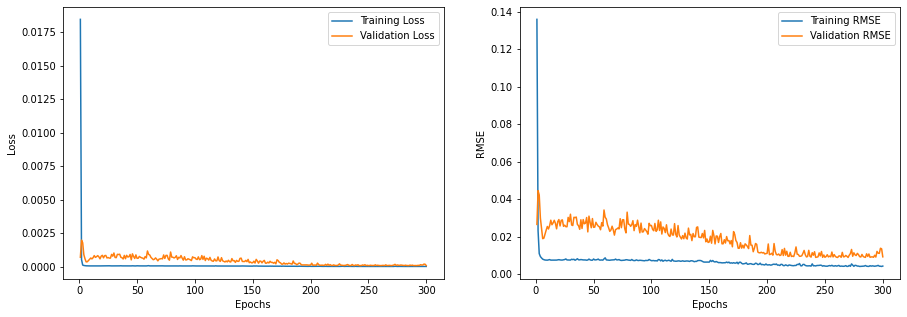

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=model.predict(X_train)
y_val_predict=model.predict(X_val)

In [ ]:
#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_t = scaler.inverse_transform(y_train)
y_val_t = scaler.inverse_transform(y_val)

In [ ]:
my_list = map(lambda x: x[0], y_train_t)
ser_1 = pd.Series(my_list)
ser_1

my_list_2 = map(lambda x: round(x[0]), y_train_predict)
ser_2 = pd.Series(my_list_2)
ser_2

pd.concat([ser_1, ser_2], names=['true','predicted'],axis= 1)

,0,1
0,5331.206250,5340
1,5331.206250,5340
2,5331.206250,5340
3,5266.493750,5340
4,5266.493750,5284
...,...,...
2296,11629.563745,11660
2297,11629.563745,11682
2298,11629.563745,11683
2299,11567.461255,11685


In [ ]:
my_list = map(lambda x: x[0], y_val_t)
ser_1 = pd.Series(my_list)
ser_1

my_list_2 = map(lambda x: round(x[0]), y_val_predict)
ser_2 = pd.Series(my_list_2)
ser_2

pd.concat([ser_1, ser_2], names=['true','predicted'],axis= 1)

,0,1
0,11567.461255,11621
1,11567.461255,11621
2,11500.851245,11622
3,11500.851245,11547
4,11500.851245,11554
...,...,...
570,17962.812500,17925
571,17962.812500,17921
572,17962.812500,17921
573,17962.812500,17921


In [ ]:
### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_t,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_t,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

Train Score: 61.63 RMSE
Test Score: 126.53 RMSE


In [ ]:
#MAPE
train_mape = mean_absolute_percentage_error(y_train_t , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_t , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

train MAPE :  0.005030706703451264
test MAPE :  0.006598123448967913


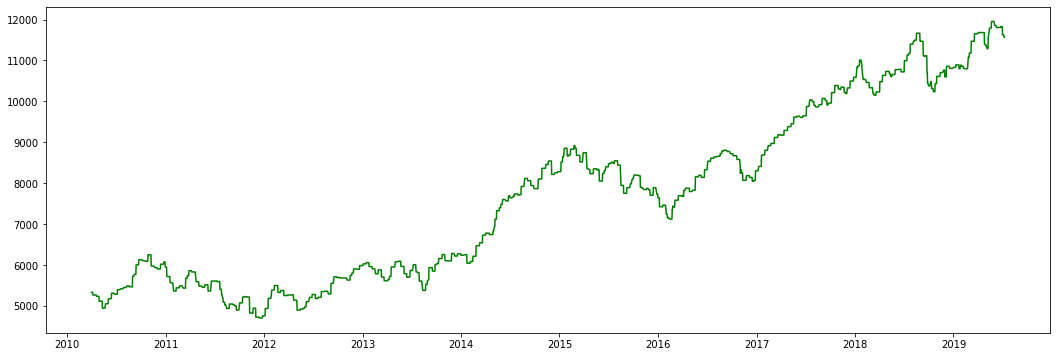

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(nifty_data_2[:len(y_train_t)].index, y_train_t, color='green', label = 'Nifty 50 Open Price')

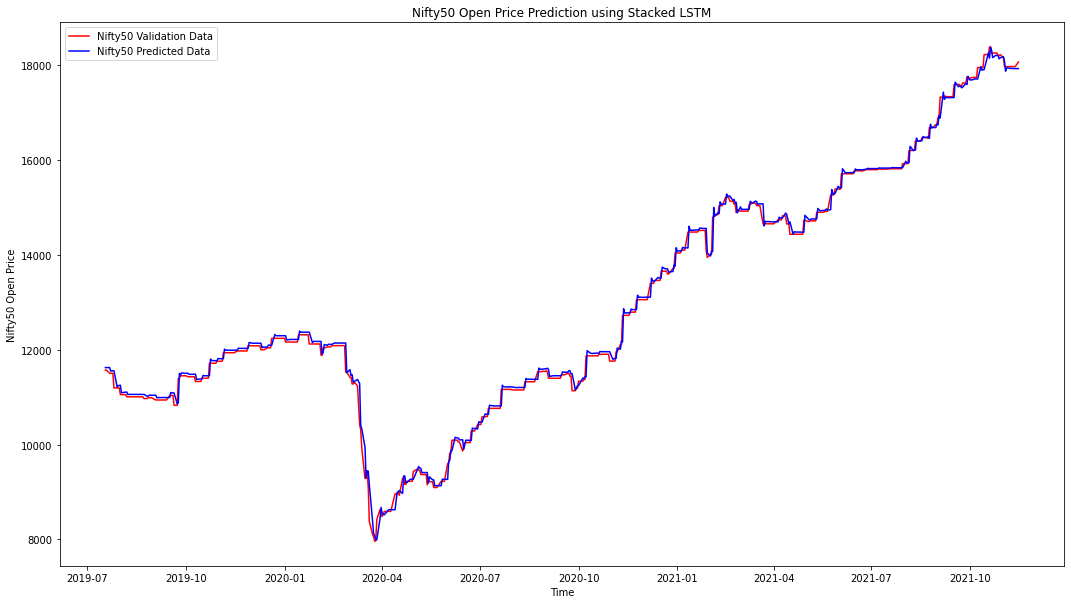

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 10))
axes.xaxis_date()
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Nifty50 Validation Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Nifty50 Predicted Data')
plt.title('Nifty50 Open Price Prediction using Stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

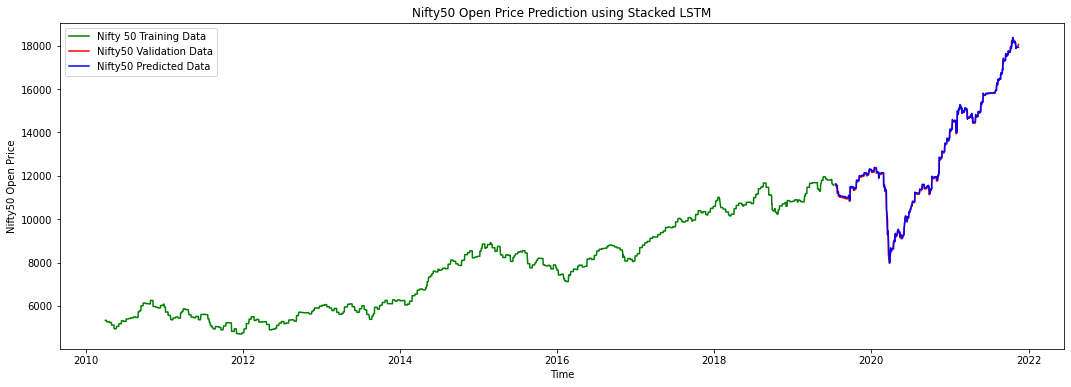

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_t)].index, y_train_t, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Nifty50 Validation Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Nifty50 Predicted Data')
plt.title('Nifty50 Open Price Prediction using Stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### Stacked LSTM_2

In [ ]:
model_1=Sequential()
model_1.add(LSTM(200,input_shape=(X_train.shape[1],1),activation = leaky_relu ,return_sequences=True))
model_1.add(LSTM(200, activation = leaky_relu))
model_1.add(Dense(200, activation = leaky_relu))
model_1.add(Dense(200 ,activation = leaky_relu))
model_1.add(Dense(50 , activation = leaky_relu))
model_1.add(Dense(1))
model_1.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

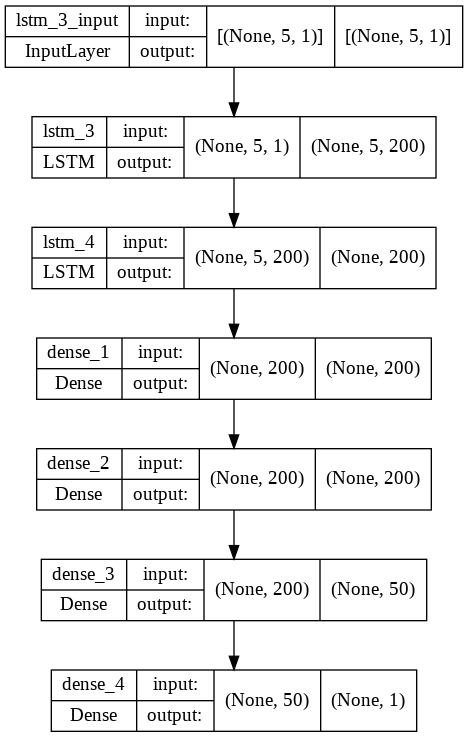

In [ ]:
plot_model(model_1, show_shapes = True)

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 200)            161600    
                                                                 
 lstm_4 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 50)                10050     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 572,901
Trainable params: 572,901
Non-tr

In [ ]:
t0 = time.time()
model_hist_1 = model_1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)

t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 60ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 2/300
36/36 [==============================] - 2s 48ms/step - loss: 3.0084e-04 - root_mean_squared_error: 0.0173 - val_loss: 6.6683e-04 - val_root_mean_squared_error: 0.0258
Epoch 3/300
36/36 [==============================] - 2s 52ms/step - loss: 5.7469e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.9820e-04 - val_root_mean_squared_error: 0.0173
Epoch 4/300
36/36 [==============================] - 2s 49ms/step - loss: 5.0627e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.4287e-04 - val_root_mean_squared_error: 0.0185
Epoch 5/300
36/36 [==============================] - 2s 51ms/step - loss: 5.0095e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.9732e-04 - val_root_mean_squared_error: 0.0172
Epoch 6/300
36/36 [==============================] - 2s 49ms/step - loss: 4.8591e-05 - root_mean_squared_err

In [ ]:
model_hist_dict = model_hist_1.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

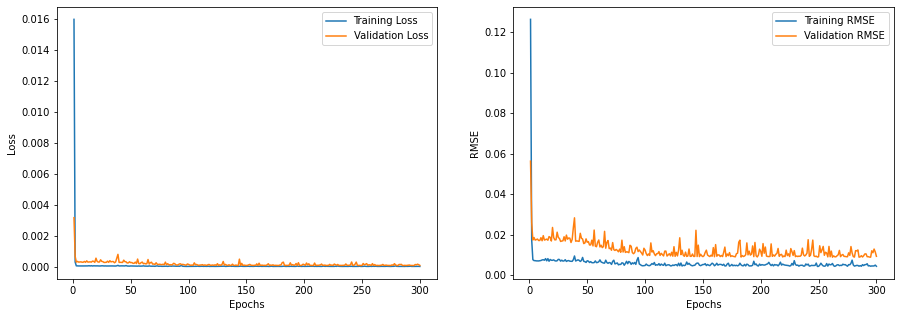

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=model_1.predict(X_train)
y_val_predict=model_1.predict(X_val)

In [ ]:
#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_t = scaler.inverse_transform(y_train)
y_val_t = scaler.inverse_transform(y_val)

In [ ]:
### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_t,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_t,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

Train Score: 63.22 RMSE
Test Score: 126.19 RMSE


In [ ]:
#MAPE
train_mape = mean_absolute_percentage_error(y_train_t , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_t , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

train MAPE :  0.006189379184234162
test MAPE :  0.006521064556650949


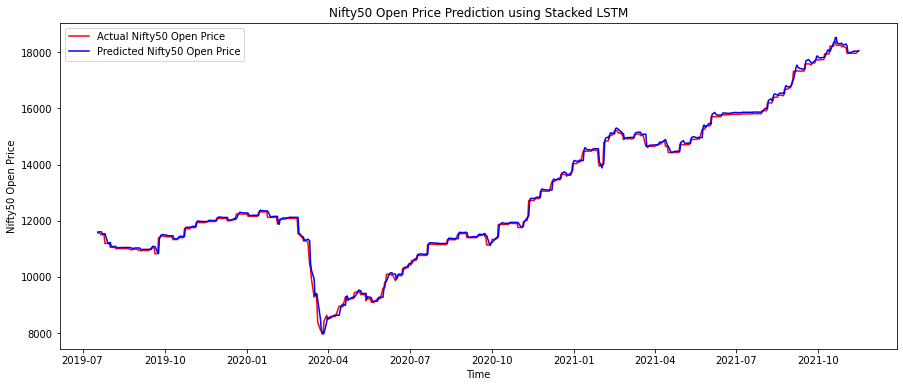

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using Stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### CNN

In [ ]:
# Defining model Architecture
network = Sequential()
network.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
network.add(MaxPooling1D(pool_size=2))
network.add(Flatten())
network.add(Dense(100, activation='relu'))
network.add(Dense(1))
# network.compile(optimizer='adam', loss='mse')
network.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

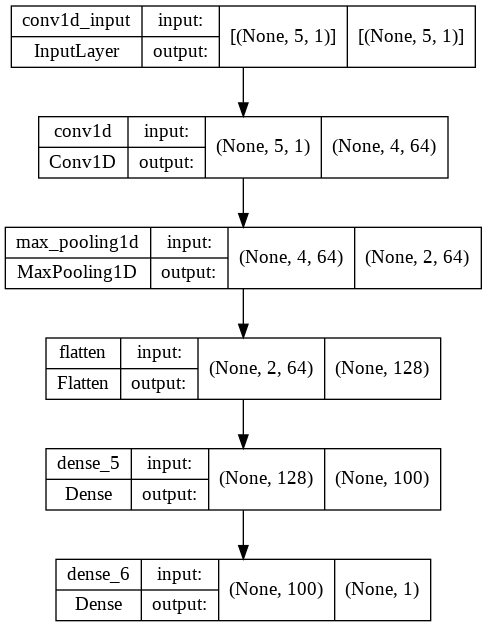

In [ ]:
plot_model(network, show_shapes = True)

In [ ]:
network.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               12900     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 13,193
Trainable params: 13,193
Non-trainable params: 0
__________________________________________________

In [ ]:
# fit model
t0 = time.time()
# network.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_2 = network.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 1s 7ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 2.5162e-04 - val_root_mean_squared_error: 0.0159
Epoch 2/300
36/36 [==============================] - 0s 3ms/step - loss: 6.8451e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.1885e-04 - val_root_mean_squared_error: 0.0148
Epoch 3/300
36/36 [==============================] - 0s 3ms/step - loss: 3.6369e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.2526e-04 - val_root_mean_squared_error: 0.0150
Epoch 4/300
36/36 [==============================] - 0s 4ms/step - loss: 3.5915e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.0905e-04 - val_root_mean_squared_error: 0.0145
Epoch 5/300
36/36 [==============================] - 0s 4ms/step - loss: 3.5097e-05 - root_mean_squared_error: 0.0059 - val_loss: 2.1780e-04 - val_root_mean_squared_error: 0.0148
Epoch 6/300
36/36 [==============================] - 0s 3ms/step - loss: 3.4048e-05 - root_mean_squared_error

In [ ]:
model_hist_dict = model_hist_2.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

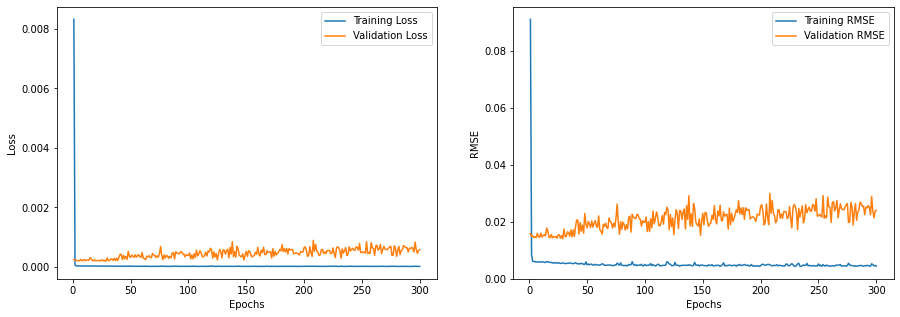

In [ ]:
## loss plotting
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict_1=network.predict(X_train)
y_val_predict_1=network.predict(X_val)


#Transformback to original form
y_train_predict_1=scaler.inverse_transform(y_train_predict_1)
y_val_predict_1=scaler.inverse_transform(y_val_predict_1)
y_train_1 = scaler.inverse_transform(y_train.reshape(-1,1))
y_val_1 = scaler.inverse_transform(y_val)


### Calculate RMSE performance metrics
train_rmse_1 = np.sqrt(mean_squared_error(y_train_1,y_train_predict_1))
### Test Data RMSE
test_rmse_1 = np.sqrt(mean_squared_error(y_val,y_val_predict_1))
print('Train Score: %.2f RMSE' % (train_rmse_1))
print('Test Score: %.2f RMSE' % (test_rmse_1))

Train Score: 56.84 RMSE
Test Score: 12994.64 RMSE


In [ ]:
#MAPE
train_mape = mean_absolute_percentage_error(y_train_1 , y_train_predict_1)
test_mape = mean_absolute_percentage_error(y_val , y_val_predict_1)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

train MAPE :  0.004059759101191976
test MAPE :  22026.257697598903


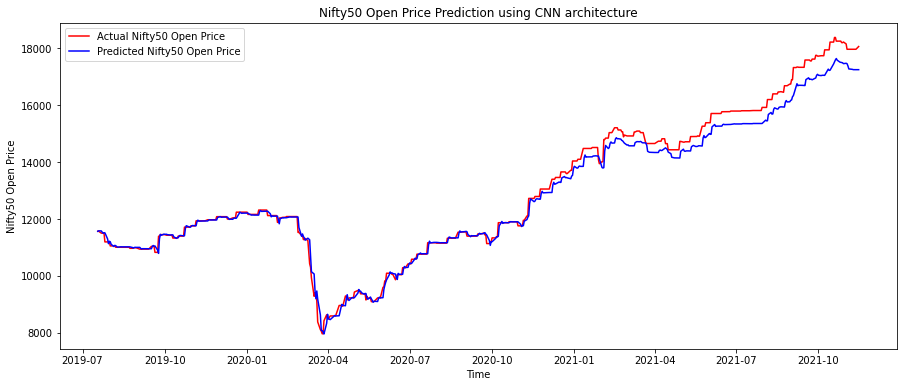

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_1):].index, y_val_1, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict_1):].index, y_val_predict_1, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN architecture')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
plt.savefig('nifty50_cnn.png')
plt.show()

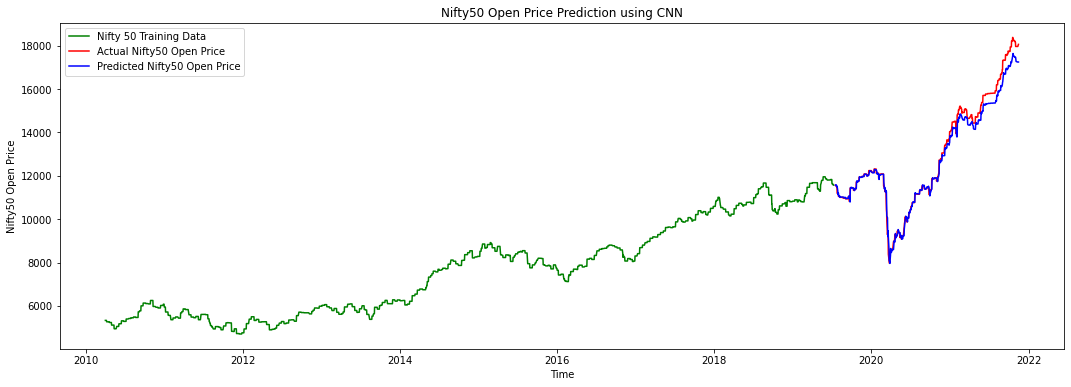

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_1)].index, y_train_1, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_1):].index, y_val_1, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict_1):].index, y_val_predict_1, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()


### CNN-LSTM

In [ ]:
# Defining model Architecture
cnn_lstm = Sequential()
cnn_lstm.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm.add(LSTM(50,return_sequences=True))
cnn_lstm.add(LSTM(50))
cnn_lstm.add(Dense(1))
# cnn_lstm.compile(optimizer='adam', loss='mse')
cnn_lstm.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

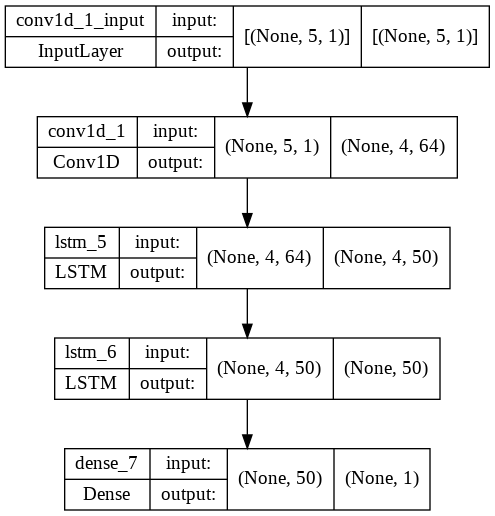

In [ ]:
plot_model(cnn_lstm, show_shapes = True)

In [ ]:
cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 lstm_5 (LSTM)               (None, 4, 50)             23000     
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 43,443
Trainable params: 43,443
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
t0 = time.time()
# cnn_lstm.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_3 = cnn_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = epochs, batch_size=batch_size, verbose = 1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 35ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 2.7846e-04 - val_root_mean_squared_error: 0.0167
Epoch 2/300
36/36 [==============================] - 0s 10ms/step - loss: 2.9397e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 3/300
36/36 [==============================] - 0s 11ms/step - loss: 7.2721e-05 - root_mean_squared_error: 0.0085 - val_loss: 8.4404e-04 - val_root_mean_squared_error: 0.0291
Epoch 4/300
36/36 [==============================] - 0s 10ms/step - loss: 5.8117e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.0632e-04 - val_root_mean_squared_error: 0.0202
Epoch 5/300
36/36 [==============================] - 0s 10ms/step - loss: 5.0371e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.9942e-04 - val_root_mean_squared_error: 0.0173
Epoch 6/300
36/36 [==============================] - 0s 10ms/step - loss: 4.7565e-05 - root_mean_squared_err

In [ ]:
model_hist_dict = model_hist_3.history

loss = model_hist_dict['loss']
root_mean_square_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1 , len(loss) + 1)

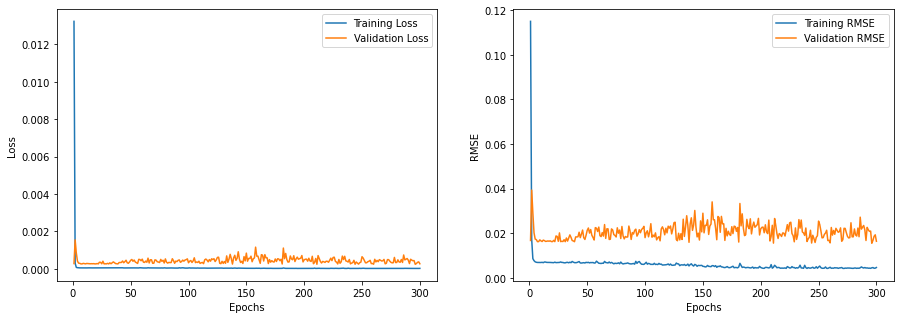

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_square_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 58.54 RMSE
Test Score: 223.25 RMSE
************************
train MAPE :  0.004223181422701094
test MAPE :  0.011089272088778775


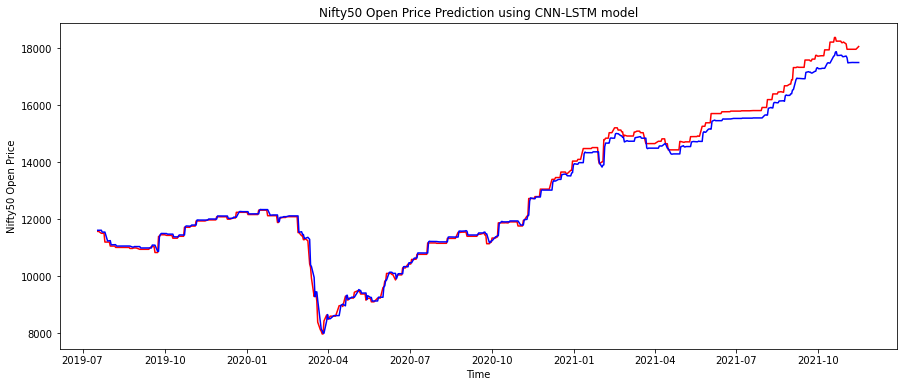

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm.predict(X_train)
y_val_predict=cnn_lstm.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_t = scaler.inverse_transform(y_train)
y_val_t = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_t,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_t,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

print('************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_t , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_t , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN-LSTM model')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


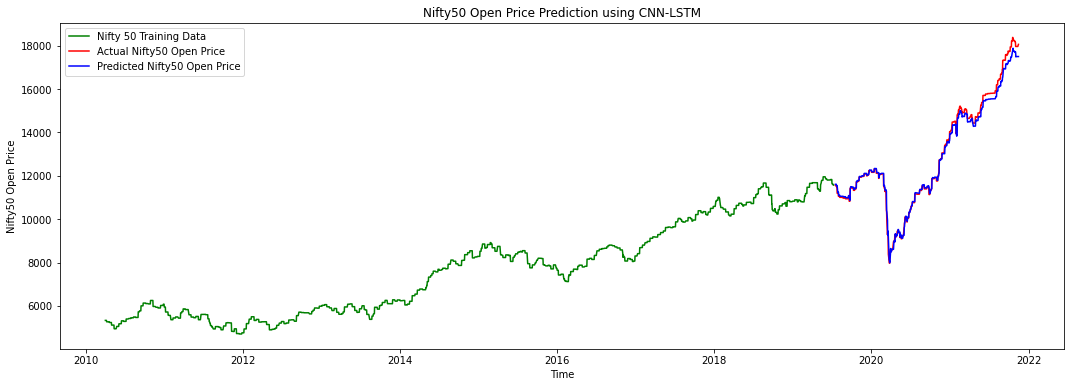

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_t)].index, y_train_t, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_t):].index, y_val_t, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
plt.show()

### CNN-LSTM 2

In [ ]:
# Defining model Architecture
cnn_lstm_2 = Sequential()
cnn_lstm_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm_2.add(MaxPooling1D(pool_size=2))
cnn_lstm_2.add(LSTM(50,return_sequences=True))
cnn_lstm_2.add(LSTM(50))
cnn_lstm_2.add(Dense(1))
# cnn_lstm_2.compile(optimizer='adam', loss='mse')
cnn_lstm_2.compile(loss= 'mean_squared_error', optimizer='adam',metrics = RootMeanSquaredError())

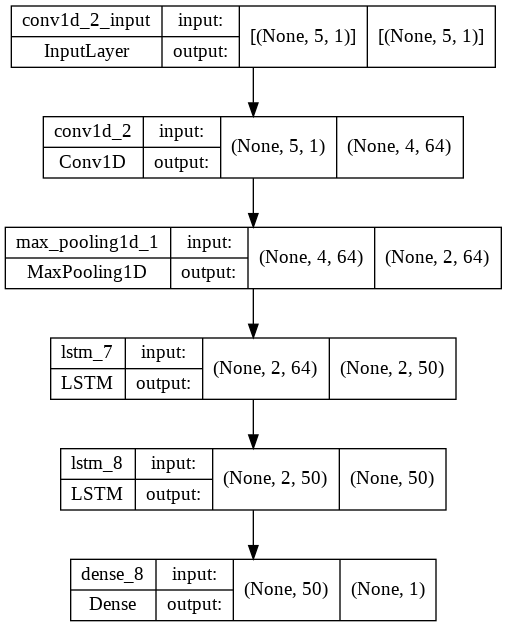

In [ ]:
plot_model(cnn_lstm_2, show_shapes = True)

In [ ]:
cnn_lstm_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 2, 50)             23000     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 43,443
Trainable params: 43,443
Non-trainable params: 0
__________________________________________________

In [ ]:
# fit model
t0 = time.time()
# cnn_lstm_2.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_4 = cnn_lstm_2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs= epochs , batch_size = batch_size , verbose = 1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 31ms/step - loss: 0.0248 - root_mean_squared_error: 0.1576 - val_loss: 0.0415 - val_root_mean_squared_error: 0.2037
Epoch 2/300
36/36 [==============================] - 0s 7ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 3/300
36/36 [==============================] - 0s 7ms/step - loss: 1.7507e-04 - root_mean_squared_error: 0.0132 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 4/300
36/36 [==============================] - 0s 9ms/step - loss: 1.0086e-04 - root_mean_squared_error: 0.0100 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 5/300
36/36 [==============================] - 0s 8ms/step - loss: 7.6536e-05 - root_mean_squared_error: 0.0087 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 6/300
36/36 [==============================] - 0s 7ms/step - loss: 6.2968e-05 - root_mean_squared_error: 0.0079 - val_loss: 9.

In [ ]:
model_hist_dict = model_hist_4.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

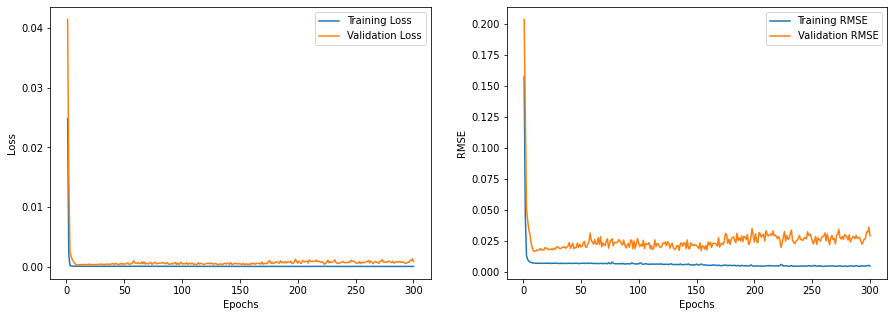

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 59.35 RMSE
Test Score: 397.85 RMSE
*************************
train MAPE :  0.004077865990135065
test MAPE :  0.019243014478255157


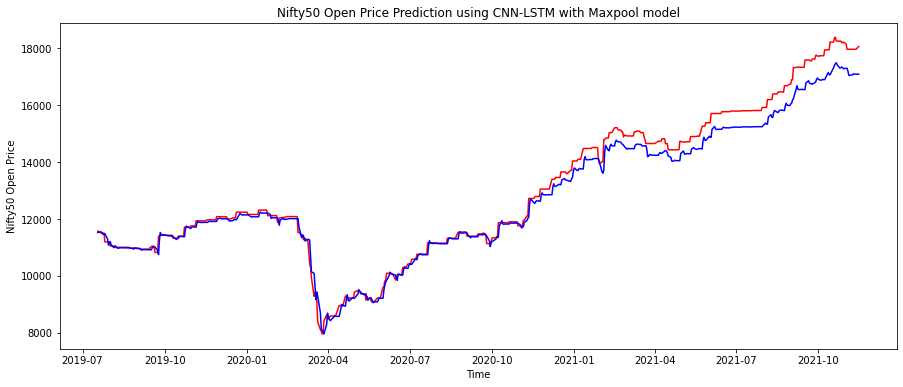

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_2.predict(X_train)
y_val_predict=cnn_lstm_2.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_cn = scaler.inverse_transform(y_train)
y_val_cn = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_cn,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_cn,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_cn , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_cn , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cn):].index, y_val_cn, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN-LSTM with Maxpool model')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


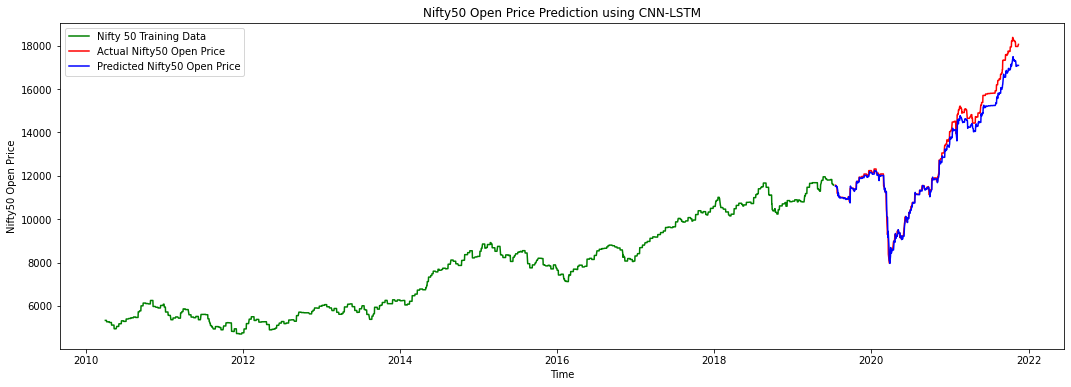

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_cn)].index, y_train_cn, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cn):].index, y_val_cn, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()


### CNN-LSTM 3

In [ ]:
# Defining model Architecture
cnn_lstm_3 = Sequential()
cnn_lstm_3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm_3.add(MaxPooling1D(pool_size=2))
cnn_lstm_3.add(Conv1D(filters=128, kernel_size=2, padding='same',activation= 'relu'))
cnn_lstm_3.add(MaxPooling1D(pool_size=2))
cnn_lstm_3.add(LSTM(50,return_sequences=True))
cnn_lstm_3.add(LSTM(50))
cnn_lstm_3.add(Dense(1))
# cnn_lstm_3.compile(optimizer='adam', loss='mse')
cnn_lstm_3.compile(loss = 'mean_squared_error',optimizer='adam',metrics = RootMeanSquaredError())

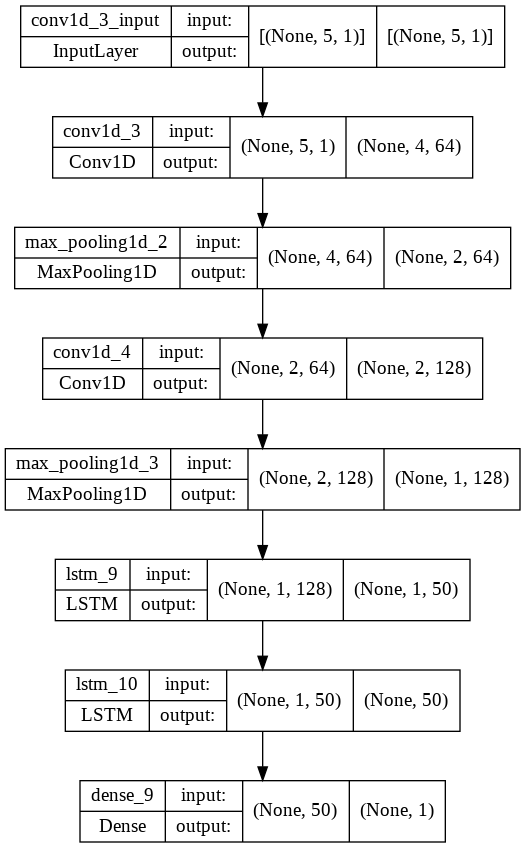

In [ ]:
plot_model(cnn_lstm_3, show_shapes= True)

In [ ]:
cnn_lstm_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 4, 64)             192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 2, 128)            16512     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 1, 50)             35800     
                                                                 
 lstm_10 (LSTM)              (None, 50)               

In [ ]:
# fit model
t0 = time.time()
# cnn_lstm_3.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_5 = cnn_lstm_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = batch_size, verbose=1)
t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 33ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0491 - val_root_mean_squared_error: 0.2217
Epoch 2/300
36/36 [==============================] - 0s 7ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 3/300
36/36 [==============================] - 0s 7ms/step - loss: 1.4548e-04 - root_mean_squared_error: 0.0121 - val_loss: 5.0519e-04 - val_root_mean_squared_error: 0.0225
Epoch 4/300
36/36 [==============================] - 0s 8ms/step - loss: 5.3776e-05 - root_mean_squared_error: 0.0073 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 5/300
36/36 [==============================] - 0s 7ms/step - loss: 3.8838e-05 - root_mean_squared_error: 0.0062 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 6/300
36/36 [==============================] - 0s 7ms/step - loss: 3.7325e-05 - root_mean_squared_error: 0.0061 - val_loss

In [ ]:
model_hist_dict = model_hist_5.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

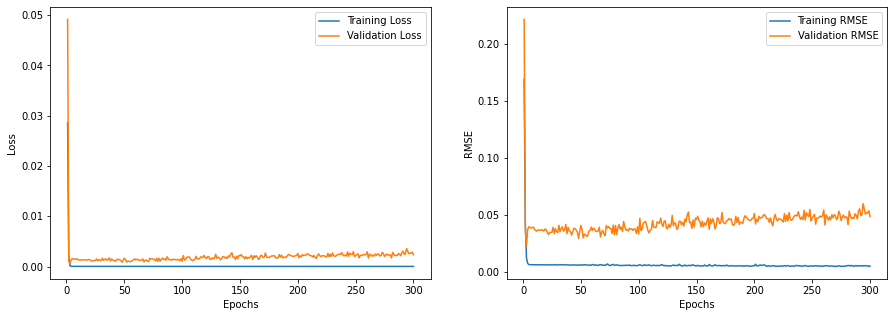

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 60.84 RMSE
Test Score: 659.72 RMSE
*************************
train MAPE :  0.004456736664367696
test MAPE :  0.027705147622857293


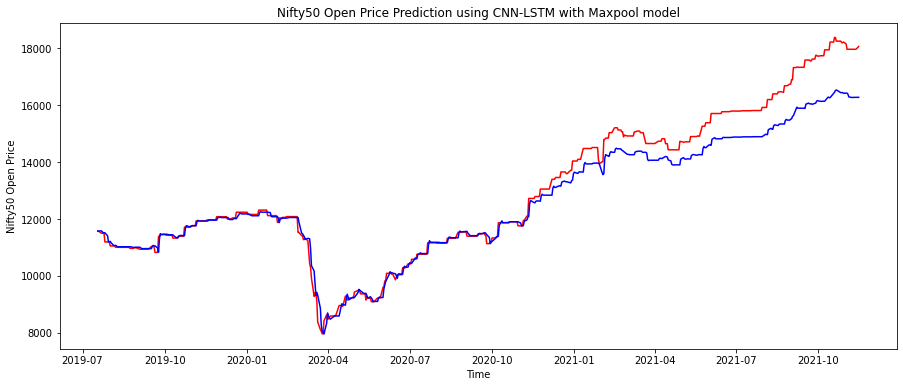

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_3.predict(X_train)
y_val_predict=cnn_lstm_3.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_cl = scaler.inverse_transform(y_train)
y_val_cl = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_cl,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_cl,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))

print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_cl , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_cl , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)


# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cl):].index, y_val_cl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using CNN-LSTM with Maxpool model')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


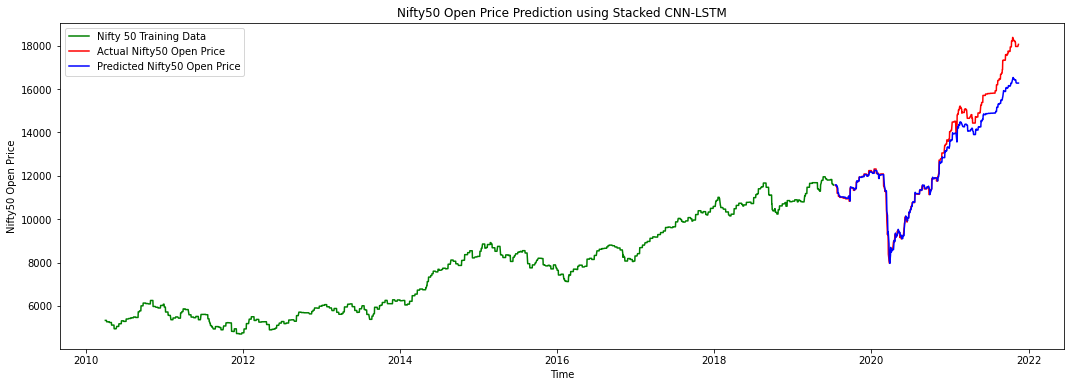

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_cl)].index, y_train_cl, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_cl):].index, y_val_cl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using Stacked CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### CNN-LSTM 4

In [ ]:
# Defining model Architecture
cnn_lstm_4 = Sequential()
cnn_lstm_4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))
cnn_lstm_4.add(Conv1D(filters=32, kernel_size=2, padding='same',activation= 'relu'))
cnn_lstm_4.add(Conv1D(filters=32, kernel_size=2, padding='same',activation= 'relu'))

cnn_lstm_4.add(LSTM(50,return_sequences=True))
cnn_lstm_4.add(LSTM(50))
cnn_lstm_4.add(Dense(1))
# cnn_lstm_4.compile(optimizer='adam', loss='mse')
cnn_lstm_4.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

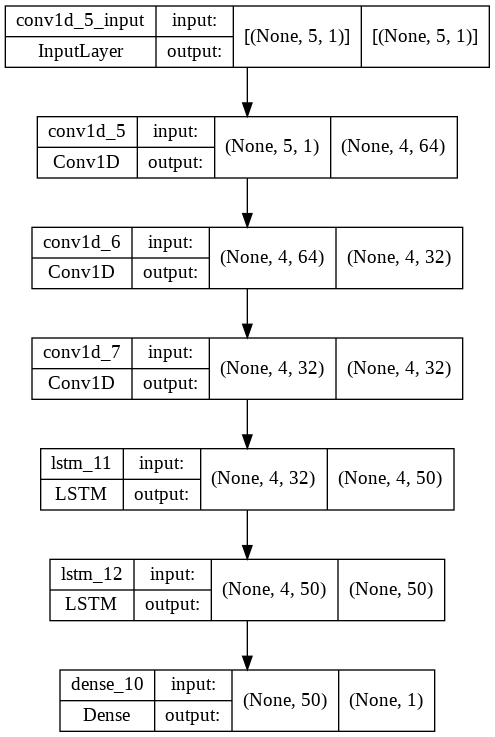

In [ ]:
plot_model(cnn_lstm_4, show_shapes=True)

In [ ]:
cnn_lstm_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 4, 64)             192       
                                                                 
 conv1d_6 (Conv1D)           (None, 4, 32)             4128      
                                                                 
 conv1d_7 (Conv1D)           (None, 4, 32)             2080      
                                                                 
 lstm_11 (LSTM)              (None, 4, 50)             16600     
                                                                 
 lstm_12 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 43,251
Trainable params: 43,251
Non-trai

In [ ]:
# fit model
t0 = time.time()
# cnn_lstm_4.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_6 = cnn_lstm_4.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)

t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 5s 34ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 8.0038e-04 - val_root_mean_squared_error: 0.0283
Epoch 2/300
36/36 [==============================] - 0s 11ms/step - loss: 3.4245e-04 - root_mean_squared_error: 0.0185 - val_loss: 3.3539e-04 - val_root_mean_squared_error: 0.0183
Epoch 3/300
36/36 [==============================] - 0s 10ms/step - loss: 5.0340e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.6259e-04 - val_root_mean_squared_error: 0.0162
Epoch 4/300
36/36 [==============================] - 0s 10ms/step - loss: 3.7308e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.8495e-04 - val_root_mean_squared_error: 0.0169
Epoch 5/300
36/36 [==============================] - 0s 11ms/step - loss: 3.5511e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.3694e-04 - val_root_mean_squared_error: 0.0154
Epoch 6/300
36/36 [==============================] - 0s 10ms/step - loss: 3.4898e-05 - root_mean_squared

In [ ]:
model_hist_dict = model_hist_6.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

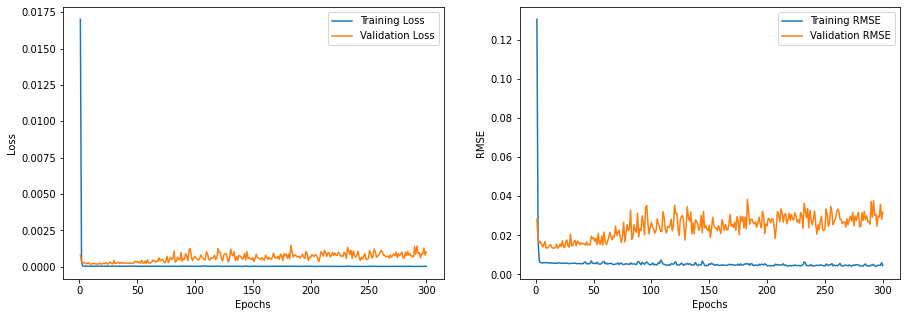

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 60.43 RMSE
Test Score: 435.33 RMSE
*************************
train MAPE :  0.004921003591246715
test MAPE :  0.020081982295085565


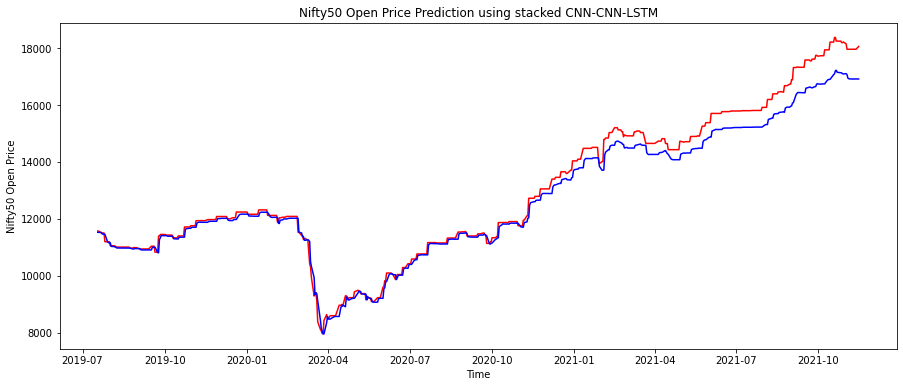

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_4.predict(X_train)
y_val_predict=cnn_lstm_4.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_ccl = scaler.inverse_transform(y_train)
y_val_ccl = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_ccl,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_ccl,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))


print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_ccl , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_ccl , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using stacked CNN-CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


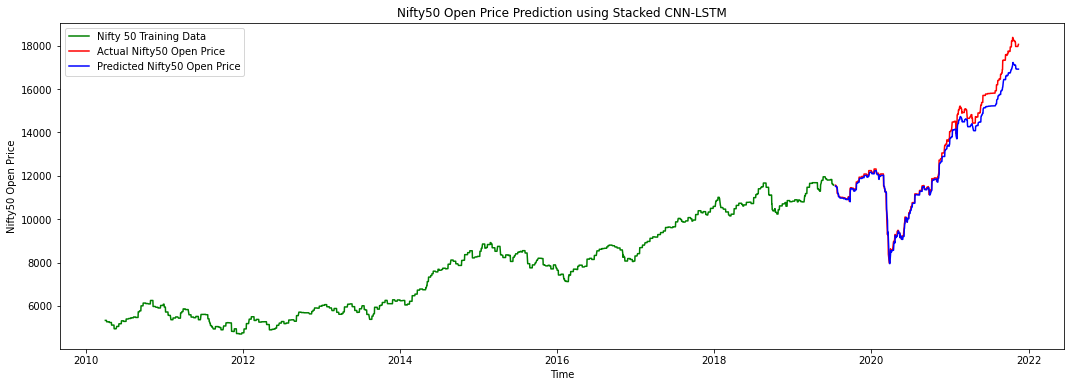

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_ccl)].index, y_train_ccl, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using Stacked CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()

### CNN-LSTM 5

In [ ]:
# Defining model Architecture
# cnn_lstm_5 = Sequential()
# cnn_lstm_5.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))

# cnn_lstm_5.add(LSTM(50,return_sequences=True))
# cnn_lstm_5.add(LSTM(50))
# cnn_lstm_5.add(Dense(20))
# cnn_lstm_5.add(Dense(1))
# # cnn_lstm_4.compile(optimizer='adam', loss='mse')
# cnn_lstm_5.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

cnn_lstm_5 = Sequential()
cnn_lstm_5.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1],1)))

cnn_lstm_5.add(LSTM(200, activation = leaky_relu, return_sequences=True))
cnn_lstm_5.add(LSTM(200, activation = leaky_relu))
cnn_lstm_5.add(Dense(200, activation = leaky_relu))
cnn_lstm_5.add(Dense(200 ,activation = leaky_relu))
cnn_lstm_5.add(Dense(50 , activation = leaky_relu))
cnn_lstm_5.add(Dense(1))
cnn_lstm_5.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())




# model_1=Sequential()
# model_1.add(LSTM(200,input_shape=(X_train.shape[1],1),activation = leaky_relu ,return_sequences=True))
# model_1.add(LSTM(200, activation = leaky_relu))
# model_1.add(Dense(200, activation = leaky_relu))
# model_1.add(Dense(200 ,activation = leaky_relu))
# model_1.add(Dense(50 , activation = leaky_relu))
# model_1.add(Dense(1))
# model_1.compile(loss='mean_squared_error',optimizer='adam', metrics = RootMeanSquaredError())

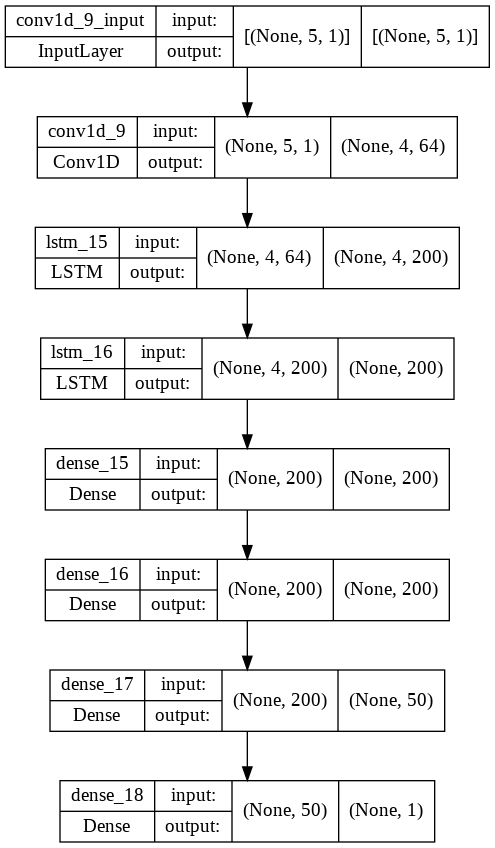

In [ ]:
plot_model(cnn_lstm_5, show_shapes=True)

In [ ]:
cnn_lstm_5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 4, 64)             192       
                                                                 
 lstm_15 (LSTM)              (None, 4, 200)            212000    
                                                                 
 lstm_16 (LSTM)              (None, 200)               320800    
                                                                 
 dense_15 (Dense)            (None, 200)               40200     
                                                                 
 dense_16 (Dense)            (None, 200)               40200     
                                                                 
 dense_17 (Dense)            (None, 50)                10050     
                                                                 
 dense_18 (Dense)            (None, 1)                

In [ ]:
# fit model
t0 = time.time()
# cnn_lstm_4.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=epochs, batch_size= batch_size, verbose=1)
model_hist_7 = cnn_lstm_5.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=batch_size,verbose=1)

t1 = time.time()
print(f"Run time : {t1 - t0}")

Epoch 1/300
36/36 [==============================] - 4s 54ms/step - loss: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 2/300
36/36 [==============================] - 2s 45ms/step - loss: 2.8188e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.7714e-04 - val_root_mean_squared_error: 0.0194
Epoch 3/300
36/36 [==============================] - 1s 41ms/step - loss: 6.0427e-05 - root_mean_squared_error: 0.0078 - val_loss: 9.2109e-04 - val_root_mean_squared_error: 0.0303
Epoch 4/300
36/36 [==============================] - 2s 43ms/step - loss: 5.0438e-05 - root_mean_squared_error: 0.0071 - val_loss: 7.3682e-04 - val_root_mean_squared_error: 0.0271
Epoch 5/300
36/36 [==============================] - 1s 40ms/step - loss: 5.1859e-05 - root_mean_squared_error: 0.0072 - val_loss: 6.3985e-04 - val_root_mean_squared_error: 0.0253
Epoch 6/300
36/36 [==============================] - 1s 41ms/step - loss: 5.5813e-05 - root_mean_squared_err

In [ ]:
model_hist_dict = model_hist_7.history

loss = model_hist_dict['loss']
root_mean_squared_error = model_hist_dict['root_mean_squared_error']
val_loss = model_hist_dict['val_loss']
val_root_mean_square_error = model_hist_dict['val_root_mean_squared_error']

epochs_p = range(1, len(loss) + 1 )

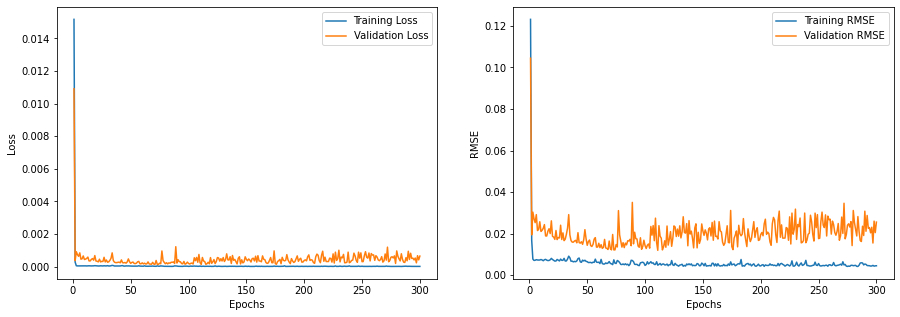

In [ ]:
fig , (ax1, ax2) = plt.subplots(1,2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs_p, loss , label = 'Training Loss')
ax1.plot(epochs_p , val_loss , label = 'Validation Loss')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.legend()

ax2.plot(epochs_p, root_mean_squared_error, label = 'Training RMSE')
ax2.plot(epochs_p , val_root_mean_square_error , label = 'Validation RMSE')
ax2.set(xlabel = 'Epochs', ylabel = 'RMSE')
ax2.legend()

plt.show()

Train Score: 61.07 RMSE
Test Score: 349.29 RMSE
*************************
train MAPE :  0.005565133749482048
test MAPE :  0.016208250342141586


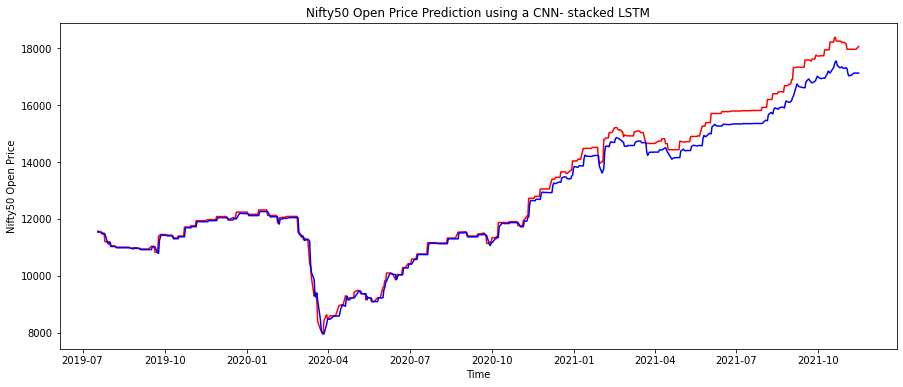

In [ ]:
### Lets Do the prediction and check performance metrics
y_train_predict=cnn_lstm_5.predict(X_train)
y_val_predict=cnn_lstm_5.predict(X_val)

#Transformback to original form
y_train_predict=scaler.inverse_transform(y_train_predict)
y_val_predict=scaler.inverse_transform(y_val_predict)
y_train_ccl = scaler.inverse_transform(y_train)
y_val_ccl = scaler.inverse_transform(y_val)

### Calculate RMSE performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train_ccl,y_train_predict))
### Test Data RMSE
test_rmse = np.sqrt(mean_squared_error(y_val_ccl,y_val_predict))
print('Train Score: %.2f RMSE' % (train_rmse))
print('Test Score: %.2f RMSE' % (test_rmse))


print('*************************')
#MAPE
train_mape = mean_absolute_percentage_error(y_train_ccl , y_train_predict)
test_mape = mean_absolute_percentage_error(y_val_ccl , y_val_predict)
print("train MAPE : ", train_mape)
print("test MAPE : ", test_mape)

# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Nifty50 Open Price Prediction using a CNN- stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.show()


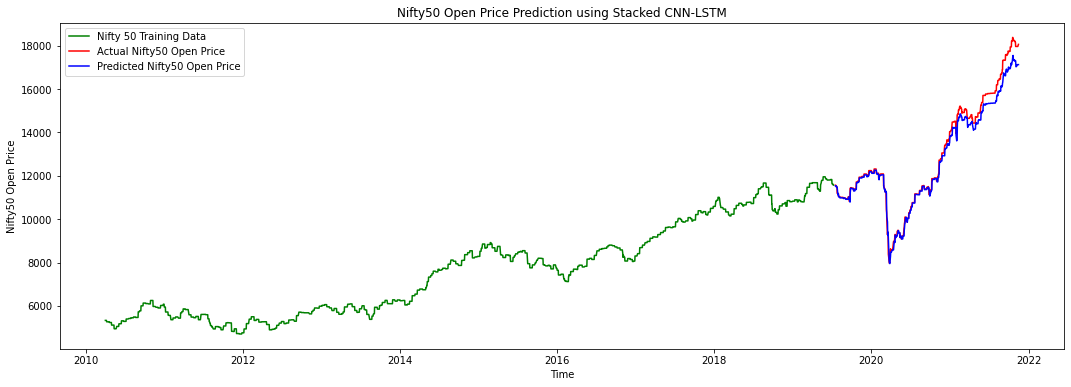

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(18, 6))
axes.xaxis_date()
plt.plot(nifty_data_2[:len(y_train_ccl)].index, y_train_ccl, color='green', label = 'Nifty 50 Training Data')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_ccl):].index, y_val_ccl, color = 'red', label = 'Actual Nifty50 Open Price')
axes.plot(nifty_data_2[len(nifty_data_2)-len(y_val_predict):].index, y_val_predict, color = 'blue', label = 'Predicted Nifty50 Open Price')
plt.title('Nifty50 Open Price Prediction using Stacked CNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Nifty50 Open Price')
plt.legend()
# plt.savefig('nifty50_lstm.png')
plt.show()